<a id='introduction'></a>

# Introduction

* This project aims to predict the likelihood of customer defaulting on telco payment based on their telco data.
* This allows the company to minimize losses when evaluating potential customers.

<a id='import'></a>

# Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import KFold

# !pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
import torch
from collections import Counter
from imblearn.over_sampling import SMOTE

import pickle

In [2]:
# Import data and view a sample
import pandas as pd
df = pd.read_csv('finantier_data_technical_test_dataset.csv', index_col=False)
df.sample()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Default
2073,9079-LWTFD,Male,0.0,No,No,47.0,Yes,Yes,Fiber optic,Yes,...,No,Yes,Yes,No,Month-to-month,No,Mailed check,100.75,4669.2,No


# Cleaning data 

* The data has been tampered with and will require some cleaning.

#### 1. Check if data samples with missing values have any valuable information

In [3]:
# check if rows with nan have important info.
df[df.isnull().any(axis=1)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Default
0,4808-GHDJN,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# If they don't, drop them
df = df.dropna().reset_index(drop=True)

#### 2. Check if Unique ID contains Duplicates, and if they should be merged

In [5]:
# no duplicates in customerID to be merged
print(max(df['customerID'].value_counts()))
df = df.drop(['customerID'], axis=1)

1


#### 3. Check that the datatypes for each feature are appropriate

In [6]:
# check that all numbers are numeric data
df.dtypes

gender               object
SeniorCitizen       float64
Partner              object
Dependents           object
tenure              float64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Default              object
dtype: object

In [7]:
# TotalCharges is not numeric, so clean and convert it
df['TotalCharges'] = df['TotalCharges'].str.strip()
df['TotalCharges'] = df['TotalCharges'].replace('', np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)
df = df.dropna().reset_index(drop=True)

# SeniorCitizen is unnecessarily numeric, so convert to boolean
df['SeniorCitizen'] = df['SeniorCitizen'].astype(bool)

<a id='preprocessing'></a>

# Data Preprocessing and Feature Engineering
* Remove Outliers, Scale Data, and Convert to Numeric Encoding for the TabNet Model

#### 1. Separate Numeric and Categorical Data for separate processing

In [8]:
# seperate numeric and categorical data for different processing
numeric_df = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
categorical_df = df.drop(labels=numeric_df.columns, axis=1)

#### 2. Visualize Outliers

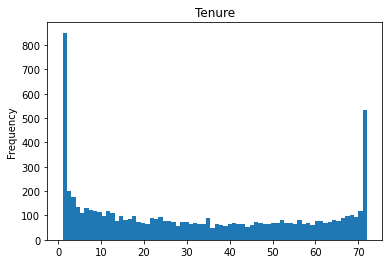

In [9]:
# numeric
plt.hist(numeric_df['tenure'], bins=70)
plt.gca().set(title='Tenure', ylabel='Frequency');

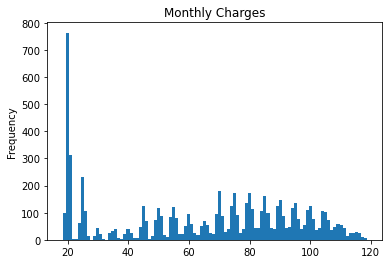

In [10]:
import matplotlib.pyplot as plt
plt.hist(numeric_df['MonthlyCharges'], bins=100)
plt.gca().set(title='Monthly Charges', ylabel='Frequency');

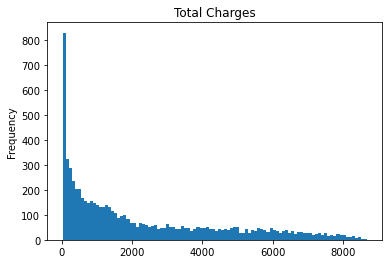

In [11]:
import matplotlib.pyplot as plt
plt.hist(numeric_df['TotalCharges'], bins=100)
plt.gca().set(title='Total Charges', ylabel='Frequency');

#### 3. Optionally remove outliers
* Note: The removal of outliers, even at >3 standard deviations, produced worse results during testing. It has therefore been left out of the process.

In [12]:
# # optional: removing outliers
# # All outlier removals have produced ~3% worse results during testing
# remove_outliers = False

# def drop_outliers(df, field_name, stdval=None):

#     if stdval is not None:
#         mean = df[field_name].mean()
#         std = df[field_name].std()
#         df = df.drop(df[df[field_name] < mean - stdval * std].index)
#         df = df.drop(df[df[field_name] > mean + stdval * std].index)

#     else:
#         distance = 1.5 * (np.nanpercentile(df[field_name], 75) - np.nanpercentile(df[field_name], 25))
#         df = df.drop(df[df[field_name] > distance + np.nanpercentile(df[field_name], 75)].index)
#         df = df.drop(df[df[field_name] < np.nanpercentile(df[field_name], 25) - distance].index)
    
#     return df

# # testdrop = {}
# if remove_outliers:
#     for col in numeric_df.columns:
#         df = drop_outliers(df, col, 3)
#     df = df.dropna().reset_index(drop=True)
#     numeric_df = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
#     categorical_df = df.drop(labels=numeric_df.columns, axis=1)

#### 4. Standardize Numeric Data to prevent large ranges and feature dominance

In [13]:
from sklearn.preprocessing import StandardScaler

scaled_features = StandardScaler().fit_transform(numeric_df.values)
scaled_numeric_df = pd.DataFrame(scaled_features, index=numeric_df.index, columns=numeric_df.columns)

scaled_numeric_df.head()

,tenure,MonthlyCharges,TotalCharges
0,-1.280248,-1.161694,-0.994194
1,0.064303,-0.260878,-0.173740
2,-1.239504,-0.363923,-0.959649
3,0.512486,-0.747850,-0.195248
4,-1.239504,0.196178,-0.940457


#### 5. Check that categorical data has a healthy number of levels and instances per level
* If extremely imbalanced or too many levels, features can be grouped or reengineered.
* However, each feature only has a few fields, so no reengineering is done.

In [14]:
# check that categorical data has a reasonable number of levels and instances per level
for col in categorical_df:
    large differences between their rangesprint(categorical_df[col].value_counts())

Male      3549
Female    3483
Name: gender, dtype: int64
False    5890
True     1142
Name: SeniorCitizen, dtype: int64
No     3639
Yes    3393
Name: Partner, dtype: int64
No     4933
Yes    2099
Name: Dependents, dtype: int64
Yes    6352
No      680
Name: PhoneService, dtype: int64
No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64
Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64
No                     3497
Yes                    2015
No internet service    1520
Name: OnlineSecurity, dtype: int64
No                     3087
Yes                    2425
No internet service    1520
Name: OnlineBackup, dtype: int64
No                     3094
Yes                    2418
No internet service    1520
Name: DeviceProtection, dtype: int64
No                     3472
Yes                    2040
No internet service    1520
Name: TechSupport, dtype: int64
No                     2809
Yes        

#### 6. Numerically Encode data for Model Processing
* Commonly, one-hot encoding is done if the data is not Ordinal (eg. pd.dummies)
* However, since Cardinality is high, one-hot encoding was not done.

In [15]:
gender_vals = ['Female', 'Male']
SeniorCitizen_vals = [False, True]
Partner_vals = ['No', 'Yes']
Dependents_vals = ['No', 'Yes']
PhoneService_vals = ['No', 'Yes']
MultipleLines_vals = ['No phone service', 'No', 'Yes']
InternetService_vals = [ 'No', 'DSL', 'Fiber optic']
OnlineSecurity_vals = ['No internet service', 'No', 'Yes']
OnlineBackup_vals = ['No internet service', 'No', 'Yes']
DeviceProtection_vals = ['No internet service', 'No', 'Yes']
TechSupport_vals = ['No internet service', 'No', 'Yes']
StreamingTV_vals = ['No internet service', 'No', 'Yes']
StreamingMovies_vals = ['No internet service', 'No', 'Yes']
Contract_vals = ['Month-to-month', 'One year', 'Two year']
PaperlessBilling_vals = ['No', 'Yes']
PaymentMethod_vals = ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']
Default_vals = ['No', 'Yes']

categorical_df['gender'] = categorical_df['gender'].apply(lambda x: gender_vals.index(x))
categorical_df['SeniorCitizen'] = categorical_df['SeniorCitizen'].apply(lambda x: SeniorCitizen_vals.index(x))
categorical_df['Partner'] = categorical_df['Partner'].apply(lambda x: Partner_vals.index(x))
categorical_df['Dependents'] = categorical_df['Dependents'].apply(lambda x: Dependents_vals.index(x))
categorical_df['PhoneService'] = categorical_df['PhoneService'].apply(lambda x: PhoneService_vals.index(x))
categorical_df['MultipleLines'] = categorical_df['MultipleLines'].apply(lambda x: MultipleLines_vals.index(x))
categorical_df['InternetService'] = categorical_df['InternetService'].apply(lambda x: InternetService_vals.index(x))
categorical_df['OnlineSecurity'] = categorical_df['OnlineSecurity'].apply(lambda x: OnlineSecurity_vals.index(x))
categorical_df['OnlineBackup'] = categorical_df['OnlineBackup'].apply(lambda x: OnlineBackup_vals.index(x))
categorical_df['DeviceProtection'] = categorical_df['DeviceProtection'].apply(lambda x: DeviceProtection_vals.index(x))
categorical_df['TechSupport'] = categorical_df['TechSupport'].apply(lambda x: TechSupport_vals.index(x))
categorical_df['StreamingTV'] = categorical_df['StreamingTV'].apply(lambda x: StreamingTV_vals.index(x))
categorical_df['StreamingMovies'] = categorical_df['StreamingMovies'].apply(lambda x: StreamingMovies_vals.index(x))
categorical_df['Contract'] = categorical_df['Contract'].apply(lambda x: Contract_vals.index(x))
categorical_df['PaperlessBilling'] = categorical_df['PaperlessBilling'].apply(lambda x: PaperlessBilling_vals.index(x))
categorical_df['PaymentMethod'] = categorical_df['PaymentMethod'].apply(lambda x: PaymentMethod_vals.index(x))
categorical_df['Default'] = categorical_df['Default'].apply(lambda x: Default_vals.index(x))

categorical_df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Default
0,0,0,1,0,0,0,1,1,2,1,1,1,1,0,1,0,0
1,1,0,0,0,1,1,1,2,1,2,1,1,1,1,0,1,0
2,1,0,0,0,1,1,1,2,2,1,1,1,1,0,1,1,1
3,1,0,0,0,0,0,1,2,1,2,2,1,1,1,0,2,0
4,0,0,0,0,1,1,2,1,1,1,1,1,1,0,1,0,1


In [16]:
cleaned_df = scaled_numeric_df.join(categorical_df)
cleaned_df.head()

,tenure,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Default
0,-1.280248,-1.161694,-0.994194,0,0,1,0,0,0,1,1,2,1,1,1,1,0,1,0,0
1,0.064303,-0.260878,-0.173740,1,0,0,0,1,1,1,2,1,2,1,1,1,1,0,1,0
2,-1.239504,-0.363923,-0.959649,1,0,0,0,1,1,1,2,2,1,1,1,1,0,1,1,1
3,0.512486,-0.747850,-0.195248,1,0,0,0,0,0,1,2,1,2,2,1,1,1,0,2,0
4,-1.239504,0.196178,-0.940457,0,0,0,0,1,1,2,1,1,1,1,1,1,0,1,0,1


## Visualize Correlation of each feature with Defaulting

<ins>**Observations**:<ins>
* Not having Internet Service is the biggest contributor to Defaulting.
* While high monthly charges are correlated with defaulting, high total charges are not. This is possibly due to the fact that total charges is correlated with tenure, and long-term customers are less likely to default.


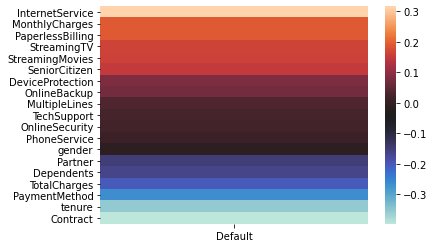

In [17]:
corr = cleaned_df.corr()[['Default']].sort_values(by=['Default'],ascending=False).drop(['Default'])

sb.heatmap(corr, cmap="icefire")

## Prepare Data for Training


In [18]:
train_val, test = train_test_split(cleaned_df, test_size=0.1)

## Resampling for Unbalanced Dataset

* The ratio of positive (default) labels to negative (no default) labels is about 1:4.
* Resampling should be done to mitigate the lowered accuracy of an imbalanced dataset.

In [19]:
# original dataset count
X_train_val = train_val.drop(['Default'], axis=1).values
y_train_val = train_val['Default'].values
counter = Counter(y_train_val)
print(counter)

# resample train dataset
oversample = SMOTE()
X_train_val, y_train_val = oversample.fit_resample(X_train_val, y_train_val)
counter = Counter(y_train_val)
print(counter)

Counter({0: 4647, 1: 1681})
Counter({0: 4647, 1: 4647})


<a id='model'></a>

# Building the model


In [20]:
features = [col for col in cleaned_df.drop(['Default'],axis=1).columns] 
cat_dims = [i for i, f in enumerate(features) if f not in ['MonthlyCharges','TotalCharges']]

## Hyperparameter Optimization with Grid Search

* After iterating through combinations of hyperparameters, the search produced optimal parameters (ROC-AUC = 0.85)
* n_d=8
* n_steps=6
* n_independent=3
* n_shared=3
* momentum=0.04
* optimizer_fn=torch.optim.Adam
* lr=2e-2

In [21]:
# # Grid Search for Hyperparameter Optimization
# predictnodes = [7,8,9,10]
# num_steps = [4,5,6,7]
# iglu = [2,3,4]
# sglu = [2,3.4]
# moms = [0.02, 0.03, 0.04]
# optimizer = torch.optim.Adam
# optimizer = torch.optim.SGD #strictly slower
# lrs = [e-2, 2e-2, e-1, 2e-1]

# # define test dataset
# X_test = test.drop(['Default'], axis=1).values
# y_test = test['Default'].values
# for p in predictnodes:
#   for ns in num_steps:
#     for ig in iglu:
#       for sg in sglu:
#         for mom in moms:
#           for lr in lrs:a

#             # get the average performance of all folds
#             res = []

#             #added some parameters
#             kf = KFold(n_splits = 4)

#             for train_index, val_index in kf.split(train_val):
#               X_train = train_val.iloc[train_index].drop(['Default'], axis=1).values
#               X_val = train_val.iloc[val_index].drop(['Default'], axis=1).values
#               y_train = train_val.iloc[train_index]['Default'].values
#               y_val = train_val.iloc[val_index]['Default'].values

#               clf = TabNetClassifier()  #TabNetRegressor()
#               clf.fit(
#                 X_train, y_train,
#                 eval_set=[(X_val, y_val)]
#               )
#               preds = clf.predict(X_test)

#               clf = TabNetClassifier(
#                   n_d=p, 
#                   n_steps=ns,
#                   n_independent=ig, 
#                   n_shared=sg,
#                   cat_dims=cat_dims,
#                   # lambda_sparse=1e-4, 
#                   momentum=mom, 
#                   optimizer_fn=optimizer,
#                   optimizer_params=dict(lr=lr),
#                   scheduler_params = {"gamma": 0.95,
#                                   "step_size": 10},
#                   scheduler_fn=torch.optim.lr_scheduler.StepLR, 
#                   epsilon=1e-15
#               )
#               clf.fit(
#                   X_train, y_train,
#                   eval_set=[(X_val, y_val)],
#                   max_epochs=100, 
#                   patience=30
#               ) 
#               preds = clf.predict(X_test)


#               accuracy = np.mean(preds == y_test)
#               print('Accuracy: ', accuracy)
#               res.append(accuracy)

#             print("Params: predictnodes=",predictnodes[i], "num_steps=", num_steps[j], "iglu", iglu[k])
#             print(sum(res) / len(res))


## Train Model with Best Parameters

In [22]:
# with best parameters
X_test = test.drop(['Default'], axis=1).values
y_test = test['Default'].values

# get the average performance of all folds
res = []

#added some parameters
kf = KFold(n_splits = 4)

for train_index, val_index in kf.split(train_val):
    X_train = train_val.iloc[train_index].drop(['Default'], axis=1).values
    X_val = train_val.iloc[val_index].drop(['Default'], axis=1).values
    y_train = train_val.iloc[train_index]['Default'].values
    y_val = train_val.iloc[val_index]['Default'].values

    clf = TabNetClassifier(
        n_d=8, 
        n_steps=6,
        # gamma=1.3, 
        n_independent=3, 
        n_shared=3,
        cat_dims=cat_dims,
        # lambda_sparse=1e-4, 
        momentum=0.04, 
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params = {"gamma": 0.95,
                      "step_size": 10},
        scheduler_fn=torch.optim.lr_scheduler.StepLR, 
        epsilon=1e-15
        )

    clf.fit(
      X_train, y_train,
      eval_set=[(X_val, y_val)],
      max_epochs=100, 
      patience=30
    ) 

    preds = clf.predict(X_test)

    accuracy = np.mean(preds == y_test)
    print('Accuracy: ', accuracy)
    res.append(accuracy)


Device used : cuda
epoch 0  | loss: 0.6521  | val_0_auc: 0.62117 |  0:00:02s
epoch 1  | loss: 0.54544 | val_0_auc: 0.6391  |  0:00:03s
epoch 2  | loss: 0.5149  | val_0_auc: 0.67823 |  0:00:04s
epoch 3  | loss: 0.50194 | val_0_auc: 0.67793 |  0:00:04s
epoch 4  | loss: 0.47896 | val_0_auc: 0.74391 |  0:00:05s
epoch 5  | loss: 0.45907 | val_0_auc: 0.71831 |  0:00:06s
epoch 6  | loss: 0.45307 | val_0_auc: 0.70935 |  0:00:06s
epoch 7  | loss: 0.45683 | val_0_auc: 0.70945 |  0:00:07s
epoch 8  | loss: 0.45509 | val_0_auc: 0.72487 |  0:00:08s
epoch 9  | loss: 0.44956 | val_0_auc: 0.74763 |  0:00:08s
epoch 10 | loss: 0.44972 | val_0_auc: 0.76432 |  0:00:09s
epoch 11 | loss: 0.44569 | val_0_auc: 0.76913 |  0:00:10s
epoch 12 | loss: 0.43942 | val_0_auc: 0.77634 |  0:00:10s
epoch 13 | loss: 0.43942 | val_0_auc: 0.78083 |  0:00:11s
epoch 14 | loss: 0.43735 | val_0_auc: 0.77808 |  0:00:12s
epoch 15 | loss: 0.43822 | val_0_auc: 0.79421 |  0:00:12s
epoch 16 | loss: 0.43195 | val_0_auc: 0.78944 |  0:00

epoch 39 | loss: 0.42434 | val_0_auc: 0.82968 |  0:00:25s
epoch 40 | loss: 0.42319 | val_0_auc: 0.8298  |  0:00:26s
epoch 41 | loss: 0.42344 | val_0_auc: 0.83569 |  0:00:27s
epoch 42 | loss: 0.41904 | val_0_auc: 0.83298 |  0:00:27s
epoch 43 | loss: 0.42083 | val_0_auc: 0.8328  |  0:00:28s
epoch 44 | loss: 0.42193 | val_0_auc: 0.83433 |  0:00:29s
epoch 45 | loss: 0.41436 | val_0_auc: 0.83244 |  0:00:29s
epoch 46 | loss: 0.41883 | val_0_auc: 0.83433 |  0:00:30s
epoch 47 | loss: 0.41576 | val_0_auc: 0.8347  |  0:00:30s
epoch 48 | loss: 0.41567 | val_0_auc: 0.83628 |  0:00:31s
epoch 49 | loss: 0.41698 | val_0_auc: 0.83433 |  0:00:32s
epoch 50 | loss: 0.41405 | val_0_auc: 0.83381 |  0:00:32s
epoch 51 | loss: 0.4175  | val_0_auc: 0.83396 |  0:00:33s
epoch 52 | loss: 0.41798 | val_0_auc: 0.83364 |  0:00:34s
epoch 53 | loss: 0.41504 | val_0_auc: 0.83581 |  0:00:34s
epoch 54 | loss: 0.41596 | val_0_auc: 0.83602 |  0:00:35s
epoch 55 | loss: 0.41788 | val_0_auc: 0.83638 |  0:00:36s
epoch 56 | los

epoch 77 | loss: 0.42817 | val_0_auc: 0.84137 |  0:00:51s
epoch 78 | loss: 0.42757 | val_0_auc: 0.84524 |  0:00:51s
epoch 79 | loss: 0.42698 | val_0_auc: 0.84385 |  0:00:52s
epoch 80 | loss: 0.42899 | val_0_auc: 0.84223 |  0:00:53s
epoch 81 | loss: 0.42361 | val_0_auc: 0.84268 |  0:00:53s

Early stopping occurred at epoch 81 with best_epoch = 51 and best_val_0_auc = 0.84953
Best weights from best epoch are automatically used!
Accuracy:  0.8167613636363636
Device used : cuda
epoch 0  | loss: 0.66756 | val_0_auc: 0.63641 |  0:00:00s
epoch 1  | loss: 0.53833 | val_0_auc: 0.56007 |  0:00:01s
epoch 2  | loss: 0.49954 | val_0_auc: 0.59689 |  0:00:02s
epoch 3  | loss: 0.48838 | val_0_auc: 0.67157 |  0:00:02s
epoch 4  | loss: 0.49134 | val_0_auc: 0.68312 |  0:00:03s
epoch 5  | loss: 0.47711 | val_0_auc: 0.70397 |  0:00:04s
epoch 6  | loss: 0.48115 | val_0_auc: 0.7472  |  0:00:05s
epoch 7  | loss: 0.47678 | val_0_auc: 0.75794 |  0:00:05s
epoch 8  | loss: 0.4692  | val_0_auc: 0.75721 |  0:00:06s

In [32]:
print("Accuracy: ", sum(res) / len(res))

Accuracy:  0.8132102272727273


# Explanations
* F1 was chosen for several reasons.
* The dataset is imbalanced (eg. model can simply always predict "No" and achieve approx. 74% accuracy
* Accuracy is more useful when we want to maximize True Positives and True negatives, while F1 score is more important when we want to avoid False Negatives and False Positives.
* In this case, mispredicting a good customer as one which will default hurts the company's bottom line, and mispredicting a defaulting customer as a good customer results in additional losses for the company.

* Note: The code uses ROC-AUC[0], the F1 score, but allows for custom thresholds.